In [1]:
import matplotlib
%matplotlib inline

import numpy as np, matplotlib as mpl
from pandas import DataFrame
import PreFRBLE
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.file_system import file_estimated_redshifts_DM


In [2]:
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18/smd'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
}

scenario_IGM = {
    'IGM' : ['primordial'],
}


file_tex_redshifts_DM = root_results+"table_redshifts_DM.tex"

full exemplary redshift estimate for the Spitler burst FRB121102

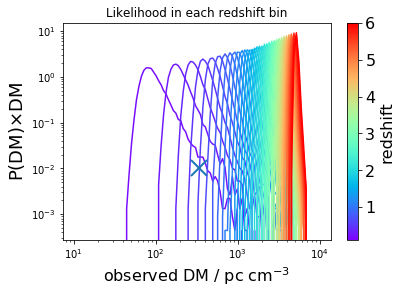

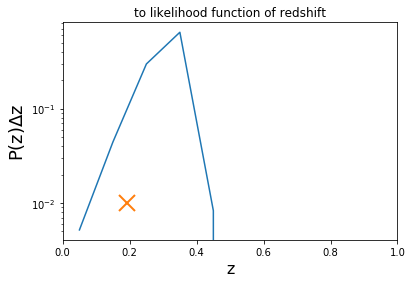

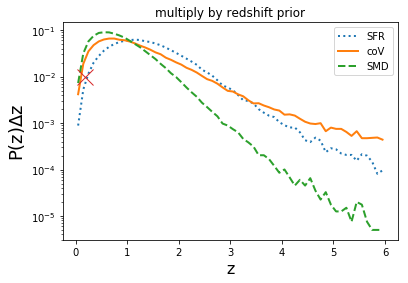

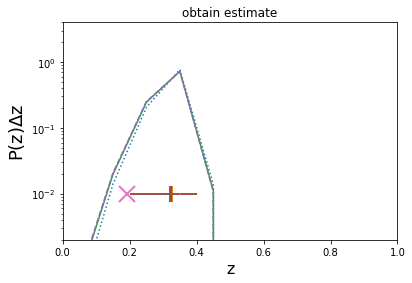

In [14]:
## Spitler burst,  Tendulkar et al. 2017
redshift_spitler = 0.19273
DM_total_spitler = 558 # pc cm^-3, total
DM_spitler = 340 # pc cm^-3, extragalactic = total-MW

telescope='Parkes'  #ARECIBO, actually  !!! PROVIDE prior vor ARECIBO



## P(DM|z) evolution with DM-marker
PlotLikelihoodEvolution( measure='DM', scenario=scenario_IGM )
plt.plot( DM_spitler, 1e-2, marker='x', markersize=16, markeredgewidth=2 )
plt.title('Likelihood in each redshift bin')
plt.show()

## P(z|DM) for flat prior with z-Marker
Ps, z = LikelihoodRedshift( DMs=[DM_spitler], population='flat', telescope='None', scenario=scenario_IGM )
PlotLikelihood(x=z, P=Ps[0], measure='z', density=False)
plt.xscale('linear')
plt.plot( redshift_spitler, 1e-2, marker='x', markersize=16, markeredgewidth=2 )
plt.title('to likelihood function of redshift')
plt.xlim(0,1)
plt.show()


## pi(z) priors with z-Marker
fig, ax = plt.subplots()
for population, linestyle in zip( populations, linestyles_population ):
    P, z = GetLikelihood_Redshift( population=population, telescope=telescope)
    PlotLikelihood(x=z, P=P, measure='z', linestyle=linestyle, ax=ax, linewidth=2, label=population, density=False)
ax.set_title('multiply by redshift prior')
ax.set_xscale('linear')
ax.legend()
ax.plot( redshift_spitler, 1e-2, marker='x', markersize=16 )
plt.show()


## P(z|DM)*pi(z) with additional estimated z-Marker
fig, ax = plt.subplots()
for population, linestyle in zip( populations, linestyles_population ):
    Ps, z = LikelihoodRedshift( DMs=[DM_spitler], population=population, telescope=telescope, scenario=scenario_IGM )
    PlotLikelihood(x=z, P=Ps[0], measure='z', linestyle=linestyle, ax=ax, density=False)
    est, dev = Likelihood2Expectation( x=z, P=Ps[0], log=False, density=True )
    ax.errorbar( est, 1e-2, xerr=dev, marker='+', markersize=16, markeredgewidth=2 )
    
ax.set_title('obtain estimate')
ax.set_xscale('linear')
ax.plot( redshift_spitler, 1e-2, marker='x', markersize=16, markeredgewidth=2 )
ax.set_xlim(0,1)
ax.set_ylim(2e-3,4)
plt.show()




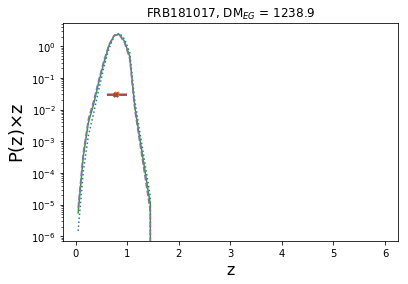

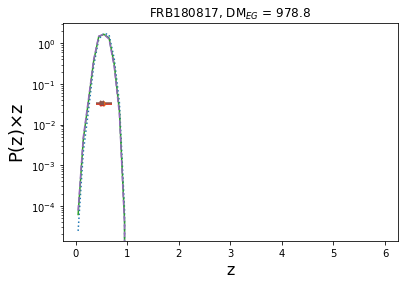

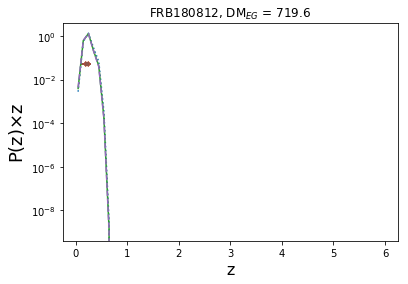

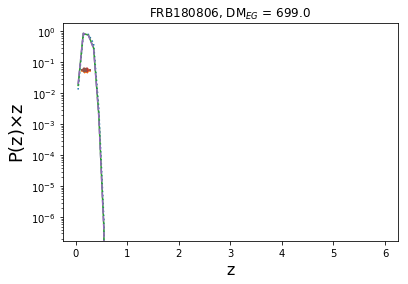

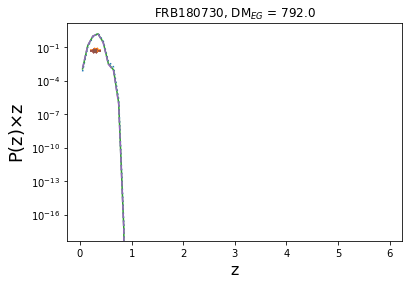

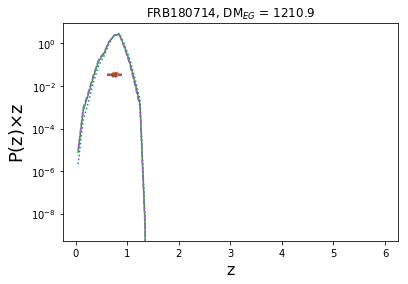

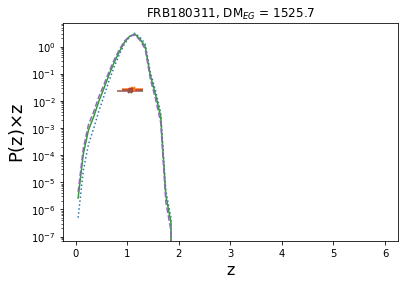

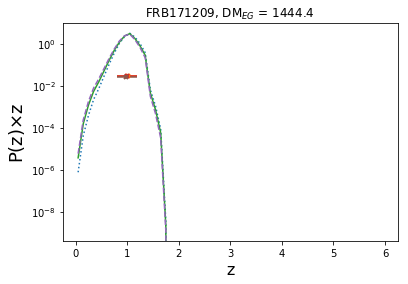

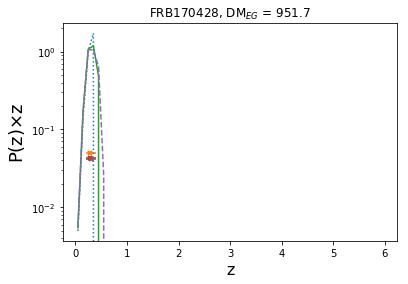

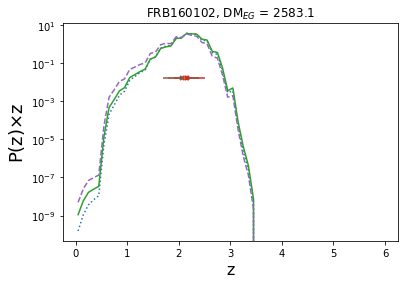

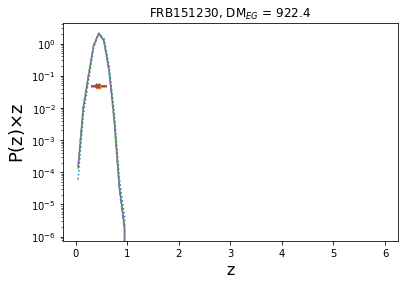

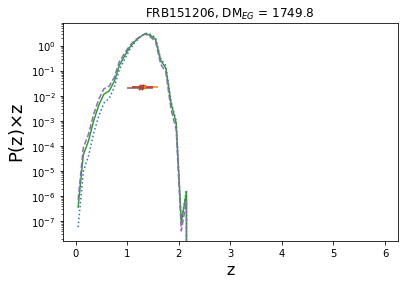

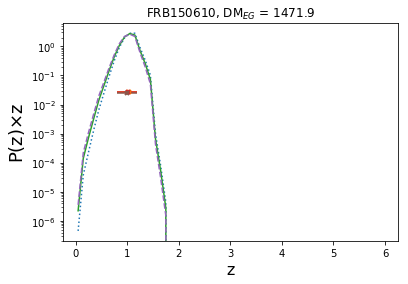

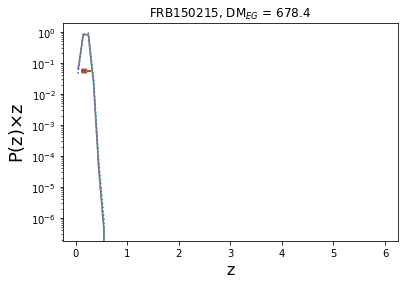

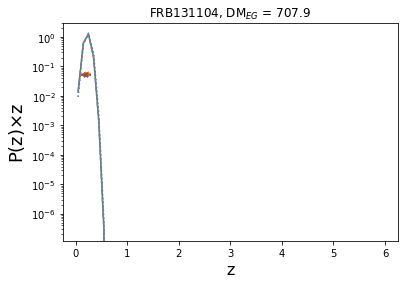

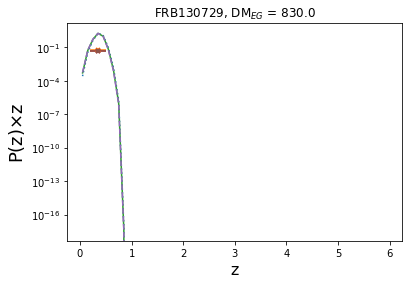

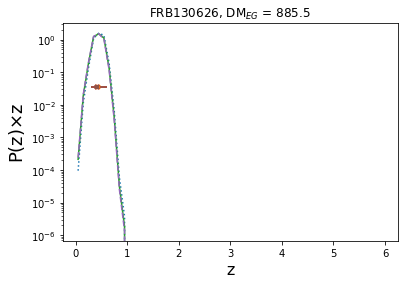

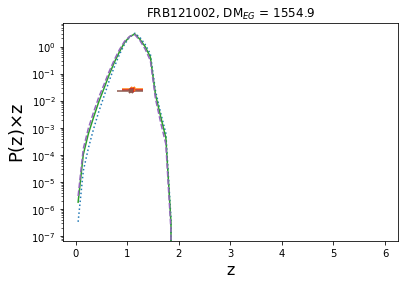

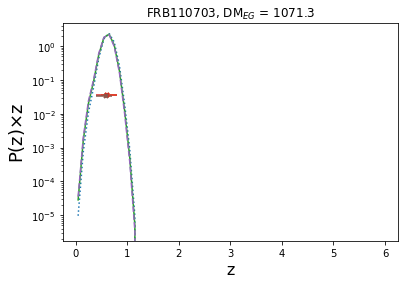

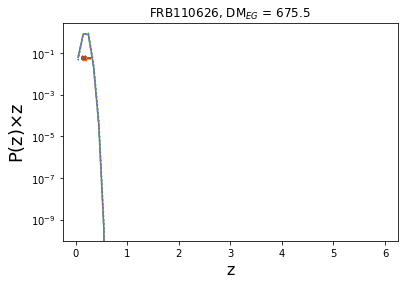

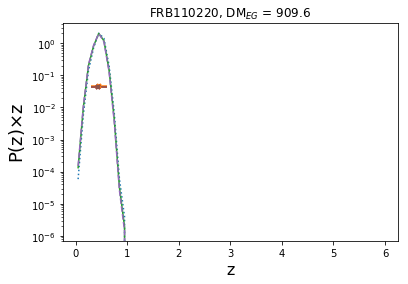

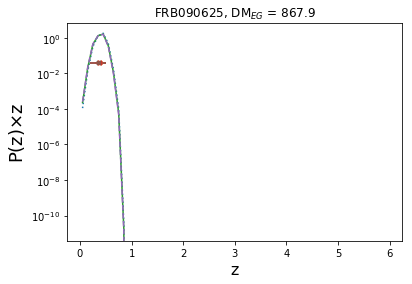

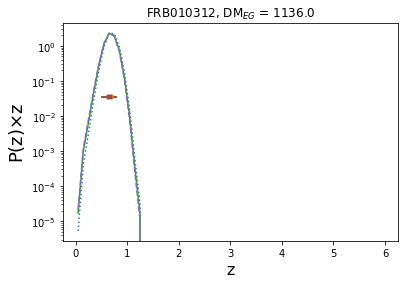

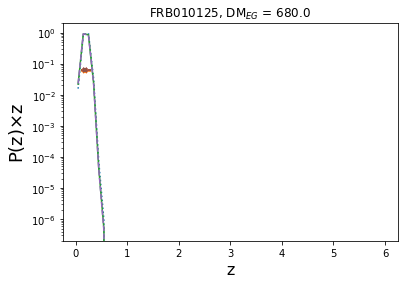

In [102]:
### estimate redshift using DM, assuming different cosmic population 
### write results in numpy array and latex table

plot=True

redshift_estimates, deviations, teles = [], [], []

with open( file_tex_redshifts_DM, 'w' ) as f:

    ## prepare header for latex tabular
    f.write( R"\begin{tabular}{l|c|c|c|c|c|c} \n\t" )
    f.write( R"ID & $\DMobs$ / $\unitDM$  & $\DMMW$ / $\unitDM$ & $z_{\rm SMD}(\DM)$  & $z_{\rm SFR}(\DM)$ & $z_{\rm coV}(\DM)$ \\" )
 
    ## load FRBs from FRBcat
    FRBs = GetFRBcat(telescopes=telescopes)

    for FRB in FRBs:
        ## estimate redshift of FRBs based on extragalactic DM, considering all populations and selection effects of the detecting telescope
        ests, devs = RedshiftEstimates( plot=False, DM=FRB['DM']-FRB['DM_gal'], telescope=telescopes_FRBcat_inv[FRB['tele']], scenario=scenario )
        
        ## only if redshift can be estimated    some have too low DM and can hence not be located in far Universe. These need to be investigated with the constrained simulation
        if not np.any(np.isnan(ests)):
            ##  collect the FRB and write entry to tabular
            redshift_estimates.append( ests )
            deviations.append( devs )
            teles.append( telescopes_FRBcat_inv[FRB['tele']] )
            if ests[0] > 0.15:  ## only write down FRBs with reasonable redshift estimates, lowest two bins are z=[0.1,0.2], so nothing below .15 can deliver lower limits
                f.write( "\n\t")
                f.write( R"%s & %.1f & %.1f & $%.2f _{-%.2f} ^{+%.2f}$ & $%.2f _{-%.2f} ^{+%.2f}$ & $%.2f _{-%.2f} ^{+%.2f}$ \\" % ( FRB['ID'], FRB['DM'], FRB['DM_gal'], ests[0], devs[0][0], devs[0][1], ests[1], devs[1][0], devs[1][1], ests[2], devs[2][0], devs[2][1] ) )
                if plot:
                    fig, ax = plt.subplots()
                    RedshiftEstimates( plot=True, DM=FRB['DM']-FRB['DM_gal'], telescope=telescopes_FRBcat_inv[FRB['tele']], scenario=scenario, ax=ax )
                    ax.set_title( "%s, DM$_{EG}$ = %.1f" % (FRB['ID'], FRB['DM']-FRB['DM_gal'] ) )
                    z_host = FRB['host_redshift']
                    if not np.isnan( z_host ):
                        ax.plot( z_host, 0.9, marker='+', markersize=10, markeredgewidth=2 )
                    plt.show()

    ## close tabular
    f.write( "\n")
    f.write( R"\end{tabular}" )

## write redshift estimates to npy file for later use. can be read with GetEstimatedRedshifts
redshift_estimates = np.array(redshift_estimates)
deviations = np.array(deviations)
names = ['redshift/SFR','dev-/SFR', 'dev+/SFR', 'redshift/coV','dev-/coV', 'dev+/coV', 'redshift/SMD','dev-/SMD', 'dev+/SMD', 'telescope']
formats = ['f','f','f','f','f','f','f','f','f','S']
dtype = np.dtype( {'names':names, 'formats':formats})
columns = [ redshift_estimates[:,0], deviations[:,0,0], deviations[:,0,1], redshift_estimates[:,1], deviations[:,1,0], deviations[:,1,1], redshift_estimates[:,2], deviations[:,2,0], deviations[:,2,1], teles ]


a = DataFrame()
for name, data in zip( names, columns ):
    a[name] = data
    
a.to_csv( file_estimated_redshifts_DM, index=False )

#a = np.array( list(zip( *columns )), dtype=dtype )
#np.savetxt( file_estimated_redshifts_DM, a )

#redshift_estimates = np.array(redshift_estimates)
#redshift_estimates.tofile( file_estimated_redshifts_DM, sep=' ')



In [12]:
FRBs = GetFRBcat( telescopes=['ASKAP'])
FRBs

array([('FRB181112', 589.27, 102.  , 10.9,  nan, 0.4755, 'ASKAP'),
       ('FRB180924', 361.42,  40.5 , 14. ,  nan, 0.3214, 'ASKAP'),
       ('FRB180525', 388.1 ,  31.  ,  nan,  nan,    nan, 'ASKAP'),
       ('FRB180515', 355.2 ,  33.  ,  nan, 0.38,    nan, 'ASKAP'),
       ('FRB180430', 264.1 , 165.44,  nan,  nan,    nan, 'ASKAP'),
       ('FRB180417', 474.8 ,  26.15,  nan,  nan,    nan, 'ASKAP'),
       ('FRB180324', 431.  ,  70.  ,  nan,  nan,    nan, 'ASKAP'),
       ('FRB180315', 479.  ,  36.  ,  nan,  nan,    nan, 'ASKAP'),
       ('FRB180212', 167.5 ,  33.  ,  nan,  nan,    nan, 'ASKAP'),
       ('FRB180131', 657.7 ,  40.  ,  nan,  nan,    nan, 'ASKAP'),
       ('FRB180130', 343.5 ,  39.  ,  nan,  nan,    nan, 'ASKAP'),
       ('FRB180128', 495.9 ,  40.  ,  nan,  nan,    nan, 'ASKAP'),
       ('FRB180128', 441.4 ,  32.  ,  nan,  nan,    nan, 'ASKAP'),
       ('FRB180119', 402.7 ,  36.  ,  nan,  nan,    nan, 'ASKAP'),
       ('FRB180110', 715.7 ,  38.  ,  nan,  nan,    nan, 'ASKA